Shape of mixed data: (1000, 13)


C:\Users\march\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\decomposition\_fastica.py:595: UserWarning: n_components is too large: it will be set to 13
  warnings.warn(
C:\Users\march\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Correlations between PCs and the original non-Gaussian signals:
Signal 1: [0.2826603335799465, 0.12156608586897313, 0.19515576788598493, 0.41170646946568024, 0.058328469004728864, 0.20346983707517646, 0.23328220638392944, 0.5064712151850403, 0.5090519215126732, 0.20118527747952056, 0.06709207829359552, 0.17240164448028192, 0.04045332447229516]
Signal 2: [0.004530864990508733, 0.055288140456425966, 0.06755197411227162, 0.27996773304017697, 0.4725502643566899, 0.2439866665734885, 0.07588312932425025, 0.1642098255290027, 0.1647124105280724, 0.3650750594258565, 0.6517679742345108, 0.0755553023526904, 0.0027956634151739858]

Correlations between ICs and the original non-Gaussian signals:
Signal 1: [0.06852070325647089, 0.029789983219609822, 0.016103149528109355, 0.008461911684180375, 0.05125873726309911, 0.06611003566979544, 0.04531353984924227, 0.002543002310045693, 0.0026642798054195738, 0.07891969783189909, 0.030400266626514134, 0.001317253335052059, 0.9855637982236602]
Signal 2: [0.0230

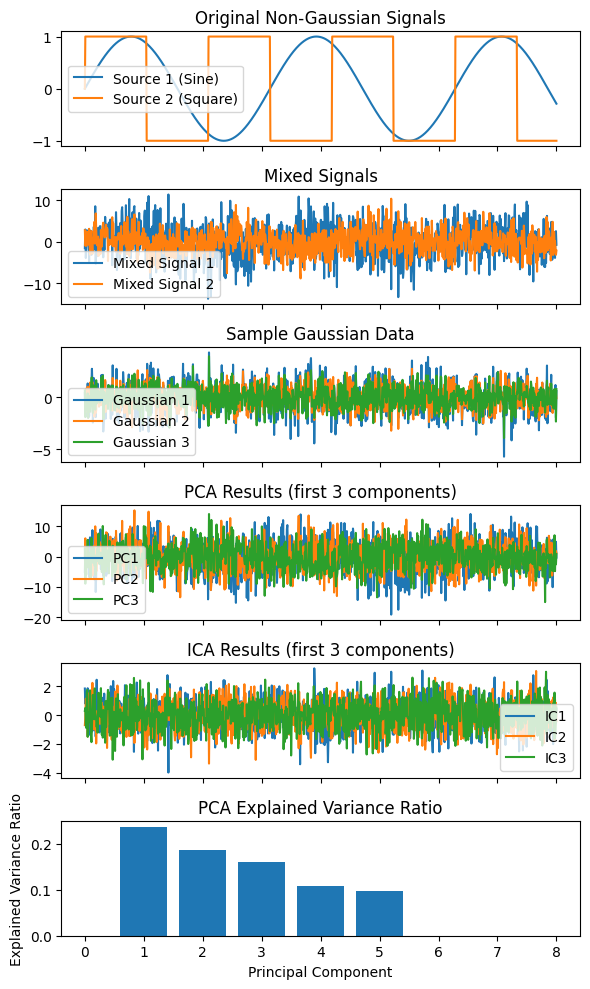

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from scipy.stats import pearsonr

np.random.seed(42)
n_samples = 1000 # analogous to number of time points
time = np.linspace(0, 8, n_samples)

# Generate two independent non-Gaussian sources
s1 = np.sin(2 * time)  # Sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Square wave

# Generate Gaussian data
n_features = 11
gaussian_data = np.random.multivariate_normal(mean=np.zeros(n_features), 
                                              cov=np.eye(n_features), 
                                              size=n_samples)

# Create strong linear relationship in the Gaussian data
gaussian_data[:, 0] = gaussian_data[:, 1] + gaussian_data[:, 2] + np.random.normal(0, 0.1, n_samples)

# # Mix the non-Gaussian sources
# mixing_matrix = np.array([[0.5, 1], [1, 0.5]])
# mixed_sources = np.c_[s1, s2].dot(mixing_matrix.T)

# Combine Gaussian and non-Gaussian data
combined_data = np.column_stack((gaussian_data, s1, s2))
num_mixed = combined_data.shape[1]  # Number of mixed signals we want to create
mixing_matrix = np.random.randn(combined_data.shape[1], num_mixed) 
mixed_data = np.dot(combined_data, mixing_matrix) # mix variables (columns) in gaussian_data and s1 and s2
X = mixed_data # The data observed (simulated)

combined_datanoIC = np.column_stack((gaussian_data, np.zeros_like(s1), np.zeros_like(s1)))
mixed_datanoIC = np.dot(combined_datanoIC, mixing_matrix) 
XnoICs = mixed_datanoIC # data with the independent components zeroed out

combined_dataonlyIC = np.column_stack((np.zeros_like(gaussian_data), s1, s1))
mixed_dataonlyIC = np.dot(combined_dataonlyIC, mixing_matrix) 
XonlyICs = mixed_dataonlyIC # data with the gaussian sources zeroed out

print("Shape of mixed data:", mixed_data.shape)

# Add some noise
X += 0.1 * np.random.normal(size=X.shape)

# Apply PCA
pca1 = PCA()
S_pca = pca1.fit_transform(X)

# Apply ICA
nICA = 15
ica = FastICA(n_components=nICA, random_state=42, max_iter=10000)
S_ica = ica.fit_transform(X) # If X is time by variables, this is temporal ICA
A_ica = ica.mixing_

# Calculate correlations between time courses and the non-gaussian sources
def calculate_correlations(S, original):
    return [[abs(pearsonr(S[:, i], original[:, j])[0]) for i in range(S.shape[1])] for j in range(2)]

pca_correlations = calculate_correlations(S_pca, np.c_[s1, s2])
ica_correlations = calculate_correlations(S_ica, np.c_[s1, s2])

print("Correlations between PCs and the original non-Gaussian signals:")
for i, corr in enumerate(pca_correlations):
    print(f"Signal {i+1}: {corr}")

print("\nCorrelations between ICs and the original non-Gaussian signals:")
for i, corr in enumerate(ica_correlations):
    print(f"Signal {i+1}: {corr}")

# Plotting
fig, axs = plt.subplots(6, 1, figsize=(6, 10), sharex=True)


print(f"Size of matrix X: {X.shape}")

# Plot original non-Gaussian signals
axs[0].plot(time, s1, label='Source 1 (Sine)')
axs[0].plot(time, s2, label='Source 2 (Square)')
axs[0].set_title('Original Non-Gaussian Signals')
axs[0].legend()

# Plot mixed signals
axs[1].plot(time, X[:, 0], label='Mixed Signal 1')
axs[1].plot(time, X[:, 1], label='Mixed Signal 2')
axs[1].set_title('Mixed Signals')
axs[1].legend()

# Plot Gaussian data
axs[2].plot(time, gaussian_data[:, 0], label='Gaussian 1')
axs[2].plot(time, gaussian_data[:, 1], label='Gaussian 2')
axs[2].plot(time, gaussian_data[:, 2], label='Gaussian 3')
axs[2].set_title('Sample Gaussian Data')
axs[2].legend()

# Plot PCA results
for i in range(3):
    axs[3].plot(time, S_pca[:, i], label=f'PC{i+1}')
axs[3].set_title('PCA Results (first 3 components)')
axs[3].legend()

# Plot ICA results
for i in range(3):
    axs[4].plot(time, S_ica[:, i], label=f'IC{i+1}')
axs[4].set_title('ICA Results (first 3 components)')
axs[4].legend()

# Plot explained variance ratio for PCA
axs[5].bar(range(1, 6), pca1.explained_variance_ratio_[:5])
axs[5].set_title('PCA Explained Variance Ratio')
axs[5].set_xlabel('Principal Component')
axs[5].set_ylabel('Explained Variance Ratio')

plt.tight_layout()
plt.show()





PCA: Maximum correlation for each nongaussian singal:
[0.50905192 0.65176797]

Index of maximum value:
[ 8 10]

ICA: Maximum correlation for each nongaussian singal:
[0.9855638  0.99486994]

Index of maximum value:
[12  5]


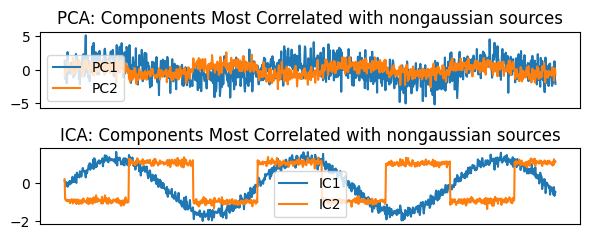

In [2]:
pca_max_correlation = np.max(pca_correlations, axis=1)
pca_max_correlation_index = np.argmax(pca_correlations, axis=1)
print("\nPCA: Maximum correlation for each nongaussian singal:")
print(pca_max_correlation)
print("\nIndex of maximum value:") # python counts from 0
print(pca_max_correlation_index)

ica_max_correlation = np.max(ica_correlations, axis=1)
ica_max_correlation_index = np.argmax(ica_correlations, axis=1)
print("\nICA: Maximum correlation for each nongaussian singal:")
print(ica_max_correlation)
print("\nIndex of maximum value:") 
print(ica_max_correlation_index)

# Plot PCA results
fig, axs = plt.subplots(2, 1, figsize=(6, 2.5), sharex=True)

for i in range(2):
    axs[0].plot(time, S_pca[:, pca_max_correlation_index[i]], label=f'PC{i+1}')
axs[0].set_title('PCA: Components Most Correlated with nongaussian sources')
axs[0].legend()
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot ICA results
for i in range(2):
    axs[1].plot(time, S_ica[:, ica_max_correlation_index[i]], label=f'IC{i+1}')
axs[1].set_title('ICA: Components Most Correlated with nongaussian sources')
axs[1].legend()
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


plt.tight_layout()
plt.show()


In [3]:
# Need to remove the selected ICA dimension before doing PCA again
# do like reconICA, build back signal, then run PCA to lower rank, then add in ICs back to dimensions, can add or remove the independent dimension

print(f"Size of matrix S_ica: {S_ica.shape}")
print(f"Size of matrix A_ica: {A_ica.shape}")
print(f"Size of matrix X: {X.shape}")

# Zero out the columns specified by ica_max_correlation_index
S_ica_zeroed = S_ica.copy()
S_ica_zeroed[:, ica_max_correlation_index] = 0
print(f"Shape of S_ica_zeroed: {S_ica_zeroed.shape}")

# # Optionally, print a few rows to verify the zeroing
# print("\nFirst few rows of S_ica_zeroed:")
# print(S_ica_zeroed[:, :])  # Adjust the number of rows as needed

X_recon_ica = S_ica_zeroed @ A_ica.T

# Perform PCA
pca = PCA()
pca.fit(X_recon_ica)
S_pcar = pca.fit_transform(X_recon_ica)

# # Calculate cumulative explained variance ratio
# cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# # scree plot
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-', linewidth=2)
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')

# # Add cumulative explained variance ratio
# plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-', linewidth=2)
# plt.legend(['Individual Explained Variance Ratio', 'Cumulative Explained Variance Ratio'])
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print("Explained variance ratio for the first 10 components:")
# for i, ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
#     print(f"PC{i}: {ratio:.4f}")



Size of matrix S_ica: (1000, 13)
Size of matrix A_ica: (13, 13)
Size of matrix X: (1000, 13)
Shape of S_ica_zeroed: (1000, 13)


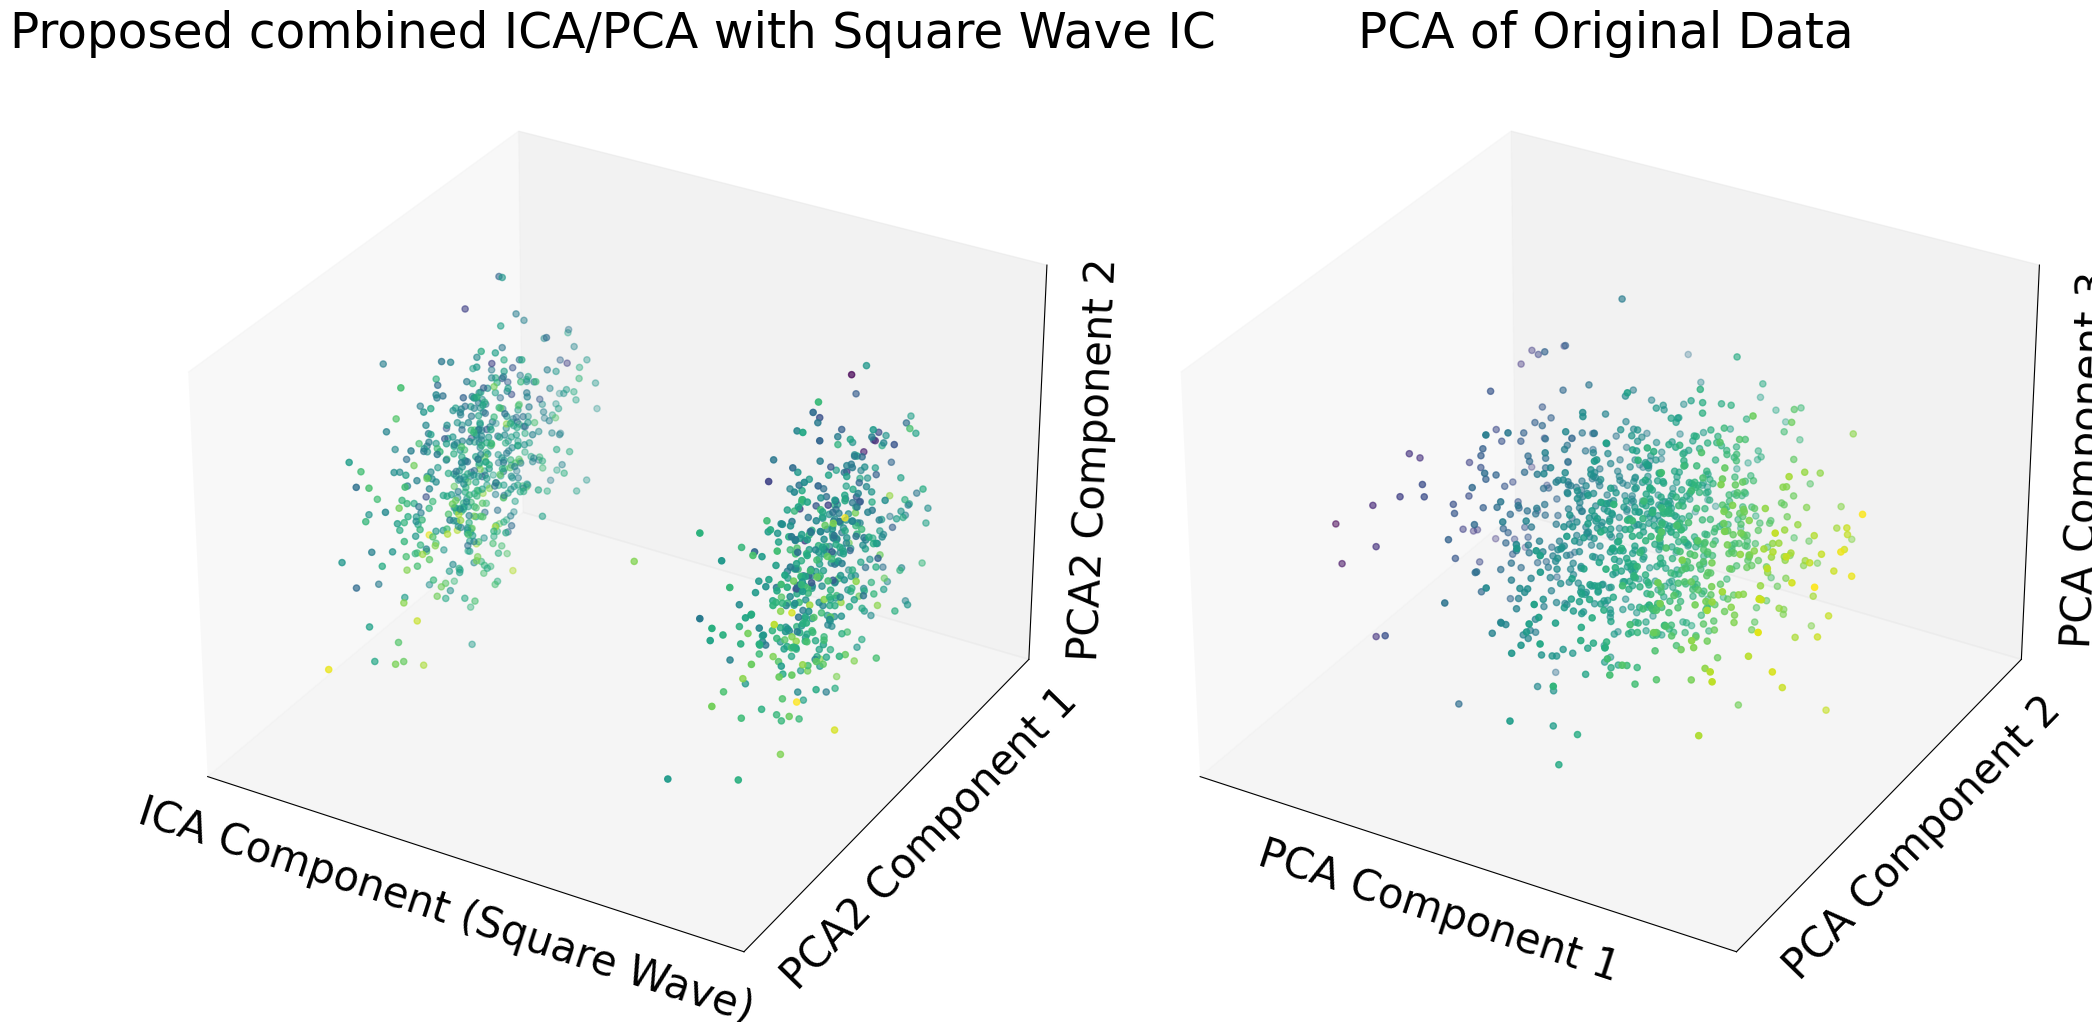

In [4]:
# Plot 3D scatter plots of 1) PCA on the original data, 
# 2) ICA-PCA basis for the data with the square wave as a dimension

# S_ica with max index with to plot with data and PCs U @ S 
# PCs with original data: S_pca
# PCs with ICs removed: S_pcar

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))

# Plot 1: ICA/PCA of the original data with the square wave as a dimension
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(S_ica[:, ica_max_correlation_index[1]], S_pcar[:, 0], S_pcar[:, 1], c=S_ica[:, 0], cmap='viridis')
size = 30
size2 = 35
ax1.set_xlabel('ICA Component (Square Wave)', fontsize=size)
ax1.set_ylabel('PCA2 Component 1', fontsize=size)
ax1.set_zlabel('PCA2 Component 2', fontsize=size)
ax1.set_title('Proposed combined ICA/PCA with Square Wave IC', fontsize=size2)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])


# Plot 2: PCA on the original data
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(S_pca[:, 0], S_pca[:, 1], S_pca[:, 2], c=S_pca[:, 0], cmap='viridis')
ax2.set_xlabel('PCA Component 1', fontsize=size)
ax2.set_ylabel('PCA Component 2', fontsize=size)
ax2.set_zlabel('PCA Component 3', fontsize=size)
ax2.set_title('PCA of Original Data', fontsize=size2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])


plt.tight_layout()
plt.show()


In [5]:

# find mse between reconned matrices and original data

print(f"Size of matrix S_pcar: {S_pcar.shape}")
print(f"Size of matrix S_pca: {S_pca.shape}")

print(f"Size of matrix pca.components: {pca.components_.shape}")
print(f"Size of matrix pca1.components: {pca.components_.shape}")

#reconstruct the estimated data
k = 7 # 11 featurs + 2 ICs, 13 maximum

mvn_hat = S_pcar[:,:k] @ pca.components_[:k,:]
X_hat = S_pca[:,:k] @ pca1.components_[:k,:]
X_hatkm2 = S_pca[:,:k-2] @ pca1.components_[:k-2,:]

kica = k - 2 
print(f"Size of matrix S_ica: {S_ica.shape}")

S_pcaica = np.column_stack((S_pcar[:,:kica], S_ica[:, ica_max_correlation_index[0]], S_ica[:, ica_max_correlation_index[1]]))
V_pcaica = np.column_stack((pca.components_[:kica,:].T, A_ica[:,ica_max_correlation_index[0]], A_ica[:,ica_max_correlation_index[1]]))
X_hatica = S_pcaica @ V_pcaica.T

X_hatpcaica = S_pcar[:,:k-2] @ pca.components_[:k-2,:]

# NEED TO ADD MEANS BACK IN? MEANS CLOSE TO 0 SO OK enough, FIX LATER.

print(f"Size of matrix X_hat: {X_hat.shape}")
print(f"Size of matrix mvn_hat: {mvn_hat.shape}")

# Calculate reconstruction errors
errorsfullpca = [np.mean((X_hat - X)**2)]
errorspcaNoICs = [np.mean((X_hat - XnoICs)**2)]
errorsfullICsrmved = [np.mean((mvn_hat - XnoICs)**2)]
errorsPCAICAwOrig = [np.mean((X_hatica - X)**2)]
errorsPCAICAwnoIC = [np.mean((X_hatpcaica - XnoICs)**2)]

errorPCAonlyICs = [np.mean((X_hat - XonlyICs)**2)]
errorPCAICAonlyICs = [np.mean((X_hatica - XonlyICs)**2)]

print(f"number of components used: {k}")
print(f"MSE of recon (PCA only ({k} PCs)) with Data w/ ICs:", errorsfullpca[0])
print(f"MSE of recon (PCA only ({k} PCs)) with Data w/o ICs:", errorspcaNoICs[0])
print(f"MSE of recon (PCA ({k} PCs) on zeroed out extracted ICs) with Data w/o ICs (smaller?):", errorsfullICsrmved[0])
print(f"MSE of recon (PCA/ICA, {k-2} PCs 2 ICs) with Data w ICs", errorsPCAICAwOrig[0])
print(f"MSE of recon (PCA only ({k} PCs)) with Data w/only ICs:", errorPCAonlyICs[0])
print(f"MSE of recon (PCA/ICA, {k-2} PCs 2 ICs) with Data w/only ICs", errorPCAICAonlyICs[0])




Size of matrix S_pcar: (1000, 13)
Size of matrix S_pca: (1000, 13)
Size of matrix pca.components: (13, 13)
Size of matrix pca1.components: (13, 13)
Size of matrix S_ica: (1000, 13)
Size of matrix X_hat: (1000, 13)
Size of matrix mvn_hat: (1000, 13)
number of components used: 7
MSE of recon (PCA only (7 PCs)) with Data w/ ICs: 0.7634190206348166
MSE of recon (PCA only (7 PCs)) with Data w/o ICs: 1.2865934490547166
MSE of recon (PCA (7 PCs) on zeroed out extracted ICs) with Data w/o ICs (smaller?): 0.42688340574063405
MSE of recon (PCA/ICA, 5 PCs 2 ICs) with Data w ICs 1.4303872756493592
MSE of recon (PCA only (7 PCs)) with Data w/only ICs: 7.875791438252992
MSE of recon (PCA/ICA, 5 PCs 2 ICs) with Data w/only ICs 6.906467405352224


In [6]:
# MSE with confidence intervals:

def mse_confidence_interval(matrix_a, matrix_b, n_iterations=1000, confidence_level=0.95):
    """
    Calculate the mean squared error (MSE) between two matrices and a confidence interval for the MSE using bootstrapping.
    
    Parameters:
    - matrix_a, matrix_b: numpy arrays, the matrices to compare
    - n_iterations: int, number of bootstrap samples (default is 1000)
    - confidence_level: float, the confidence level for the interval (default is 0.95)
    
    Returns:
    - original_mse: float, the MSE between the original matrices
    - ci_lower: float, lower bound of the confidence interval
    - ci_upper: float, upper bound of the confidence interval
    """
    
    # Function to calculate MSE
    def mse(mat1, mat2):
        return np.mean((mat1 - mat2) ** 2)
    
    # Compute the original MSE
    original_mse = mse(matrix_a, matrix_b)
    
    # Flatten the matrices for easier sampling
    flat_a = matrix_a.flatten()
    flat_b = matrix_b.flatten()
    n_elements = len(flat_a)
    
    # Bootstrapping to obtain confidence interval for MSE
    mse_values = []
    for _ in range(n_iterations):
        # Sample indices with replacement
        indices = np.random.choice(n_elements, n_elements, replace=True)
        sample_a = flat_a[indices]
        sample_b = flat_b[indices]
        
        # Calculate MSE for the sample and store it
        mse_values.append(mse(sample_a, sample_b))
    
    # Calculate the confidence interval
    lower_percentile = (1 - confidence_level) / 2 * 100 # (area of pdfs based on bootstrap estimation)
    upper_percentile = (1 + confidence_level) / 2 * 100
    ci_lower = np.percentile(mse_values, lower_percentile)
    ci_upper = np.percentile(mse_values, upper_percentile)
    
    return original_mse, ci_lower, ci_upper

# # Example usage:
# # Replace matrix_a and matrix_b with your actual matrices
# np.random.seed(0)  # For reproducibility
# matrix_a = np.random.rand(10, 10)
# matrix_b = matrix_a + np.random.normal(0, 0.1, (10, 10))
# # Calculate MSE and confidence interval
# original_mse, ci_lower, ci_upper = mse_confidence_interval(matrix_a, matrix_b)
# print("Original MSE:", original_mse)
# print("95% Confidence Interval:", (ci_lower, ci_upper))

print(f"number of components used: {k}")
mseXhatX, ci_lower, ci_upper = mse_confidence_interval(X_hat, X)
print(f"MSE of recon (PCA only ({k} PCs)) with Data w/ ICs: {mseXhatX:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]")
mseXhatXnoICs, ci_lower, ci_upper = mse_confidence_interval(X_hat, XnoICs)
print(f"MSE of recon (PCA only ({k} PCs)) with Data w/o ICs: {mseXhatXnoICs:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]" )
msemvnhatXnoICs, ci_lower, ci_upper = mse_confidence_interval(mvn_hat, XnoICs)
print(f"MSE of recon (PCA ({k} PCs) on zeroed out IC recon) with Data w/o ICs: {msemvnhatXnoICs:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]")
mseXhaticaX, ci_lower, ci_upper = mse_confidence_interval(X_hatica, X)
print(f"MSE of recon (combined PCA/ICA basis, {k-2} PCs and 2 ICs) with Data w/ ICs: {mseXhaticaX:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]")
mseXhatpcaicaXnoICs, ci_lower, ci_upper = mse_confidence_interval(X_hatpcaica, XnoICs)
print(f"MSE of recon (PCA ({k-2} PCs) on zeroed out IC recon) with Data w/o ICs: {mseXhatpcaicaXnoICs:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]")
mseXhatXonlyICs, ci_lower, ci_upper = mse_confidence_interval(X_hat, XonlyICs)
print(f"MSE of recon (PCA only ({k} PCs)) with Data w/only ICs: {mseXhatXonlyICs:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]")
mseXhaticaXonlyICs, ci_lower, ci_upper = mse_confidence_interval(X_hatica, XonlyICs)
print(f"MSE of recon (PCA/ICA, {k-2} PCs 2 ICs) with Data w/only ICs: {mseXhaticaXonlyICs:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]")
mseXhatkm2XnoICs, ci_lower, ci_upper = mse_confidence_interval(X_hatkm2, XnoICs)
print(f"MSE of recon (PCA only ({k-2} PCs)) with Data w/o ICs: {mseXhatkm2XnoICs:.2f} 95% confidence interval: [{ci_lower:.2f},{ci_upper:.2f}]" )



number of components used: 7
MSE of recon (PCA only (7 PCs)) with Data w/ ICs: 0.76 95% confidence interval: [0.74,0.79]
MSE of recon (PCA only (7 PCs)) with Data w/o ICs: 1.29 95% confidence interval: [1.26,1.32]
MSE of recon (PCA (7 PCs) on zeroed out IC recon) with Data w/o ICs: 0.43 95% confidence interval: [0.41,0.44]
MSE of recon (combined PCA/ICA basis, 5 PCs and 2 ICs) with Data w/ ICs: 1.43 95% confidence interval: [1.38,1.48]
MSE of recon (PCA (5 PCs) on zeroed out IC recon) with Data w/o ICs: 1.43 95% confidence interval: [1.38,1.49]
MSE of recon (PCA only (7 PCs)) with Data w/only ICs: 7.88 95% confidence interval: [7.66,8.10]
MSE of recon (PCA/ICA, 5 PCs 2 ICs) with Data w/only ICs: 6.91 95% confidence interval: [6.71,7.12]
MSE of recon (PCA only (5 PCs)) with Data w/o ICs: 2.19 95% confidence interval: [2.13,2.25]
